In [1]:
from ftw_tools.torchgeo.datasets import FTW
from ftw_tools.torchgeo.datamodules import preprocess
from torch.utils.data import DataLoader
from ftw_tools.torchgeo.trainers import CustomSemanticSegmentationTask
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Note, scikit-learn is not a dependency of ftw-tools, so you may need to `pip install scikit-learn`
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda:0")

In [3]:
task = CustomSemanticSegmentationTask.load_from_checkpoint("../3_Class_FULL_FTW_Pretrained.ckpt", map_location="cpu")
model = task.model
model = model.to(device).eval()

Using custom trainer
"backbone":        efficientnet-b3
"class_weights":   [0.04, 0.08, 0.88]
"freeze_backbone": False
"freeze_decoder":  False
"ignore_index":    3
"in_channels":     8
"loss":            ce
"lr":              0.001
"model":           unet
"model_kwargs":    {}
"num_classes":     3
"num_filters":     64
"patch_weights":   False
"patience":        100


In [4]:
latvia_ds = FTW(
    root="../data/ftw",
    countries=["latvia"],
    split="train",
    transforms=preprocess,
)
lithuania_ds = FTW(
    root="../data/ftw",
    countries=["lithuania"],
    split="train",
    transforms=preprocess,
)
spain_ds = FTW(
    root="../data/ftw",
    countries=["spain"],
    split="train",
    transforms=preprocess,
)

latvia_dl = DataLoader(latvia_ds, batch_size=32, shuffle=False, num_workers=8)
lithuania_dl = DataLoader(lithuania_ds, batch_size=32, shuffle=False, num_workers=8)
spain_dl = DataLoader(spain_ds, batch_size=32, shuffle=False, num_workers=8)

Loading 2 Class Masks, without Boundaries
Temporal option:  stacked
Using window B first, then window A
Selecting :  5529  samples
Loading 2 Class Masks, without Boundaries
Temporal option:  stacked
Using window B first, then window A
Selecting :  4208  samples
Loading 2 Class Masks, without Boundaries
Temporal option:  stacked
Using window B first, then window A
Selecting :  2015  samples


In [5]:
zs = []
country_ids = []
for batch in tqdm(latvia_dl):
    images = batch["image"].to(device)
    with torch.inference_mode():
        features = model.encoder(images)
        decoder_output = model.decoder(features)
        z = decoder_output.mean(dim=(2,3)).cpu().numpy()
        zs.append(z)
        country_ids.append(np.zeros(z.shape[0]))

for batch in tqdm(lithuania_dl):
    images = batch["image"].to(device)
    with torch.inference_mode():
        features = model.encoder(images)
        decoder_output = model.decoder(features)
        z = decoder_output.mean(dim=(2,3)).cpu().numpy()
        zs.append(z)
        country_ids.append(np.ones(z.shape[0]))

for batch in tqdm(spain_dl):
    images = batch["image"].to(device)
    with torch.inference_mode():
        features = model.encoder(images)
        decoder_output = model.decoder(features)
        z = decoder_output.mean(dim=(2,3)).cpu().numpy()
        zs.append(z)
        country_ids.append(np.ones(z.shape[0]) + 1)

100%|██████████| 63/63 [00:06<00:00,  9.89it/s]


In [6]:
zs = np.concatenate(zs)
country_ids = np.concatenate(country_ids)

In [7]:
zs.shape

(11752, 16)

In [8]:
transformer = PCA(n_components=2)
zs_pca = transformer.fit_transform(zs)

In [9]:
transformer.explained_variance_ratio_.sum()

np.float32(0.9083059)

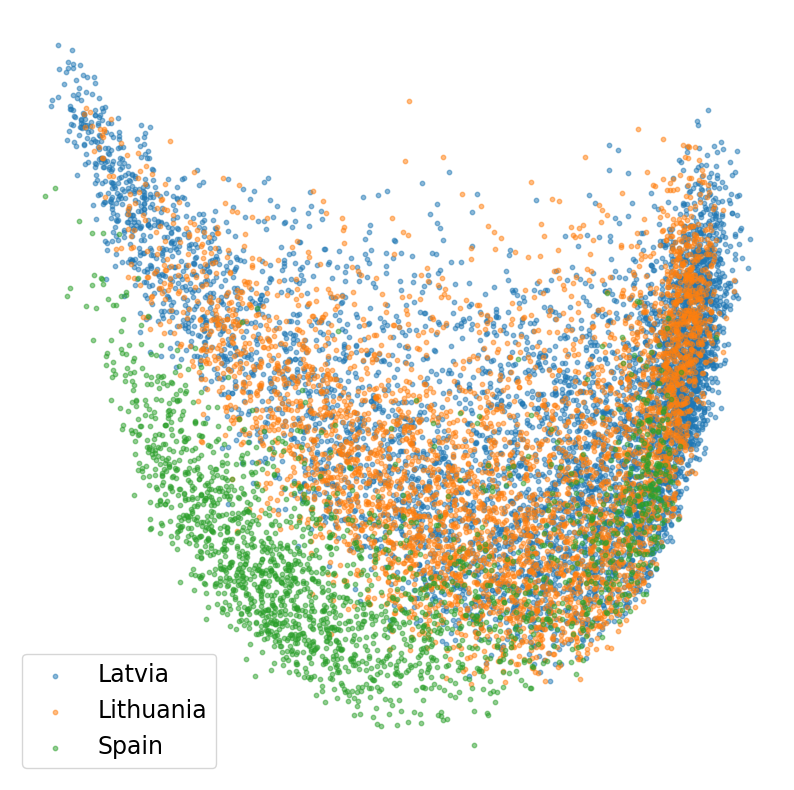

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(zs_pca[country_ids == 0, 0], zs_pca[country_ids == 0, 1], s=10, alpha=0.5, label="Latvia")
plt.scatter(zs_pca[country_ids == 1, 0], zs_pca[country_ids == 1, 1], s=10, alpha=0.5, label="Lithuania")
plt.scatter(zs_pca[country_ids == 2, 0], zs_pca[country_ids == 2, 1], s=10, alpha=0.5, label="Spain")
plt.legend(fontsize=17)
plt.axis("off")
plt.show()
plt.close()